In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
flight_data = pd.read_csv('flight_data_kiwi_allsnaps_clean_step2.csv') #קריאת הנתונים

In [3]:
# Defining airport to city mappings
airport_to_city = {
    'BVA': 'Paris', 'ORY': 'Paris', 'PAR': 'Paris', 'CDG': 'Paris',
    'CIA': 'Rome', 'FCO': 'Rome',
    'SEN': 'London', 'LCY': 'London', 'STN': 'London', 'LHR': 'London', 'LGW': 'London', 'LTN': 'London'
}

# Airports to cities
flight_data['From City'] = flight_data['From'].map(airport_to_city)
flight_data['Landing City'] = flight_data['Landing'].map(airport_to_city)

In [ ]:
# Function to convert duration to minutes
def convert_duration_to_minutes(duration):
    hours, minutes = 0, 0
    # Extract hours and minutes using regex
    match = re.match(r'(\d+)h (\d+)m', duration)
    if match:
        hours, minutes = int(match.group(1)), int(match.group(2))
    else:
        match = re.match(r'(\d+)h', duration)
        if match:
            hours = int(match.group(1))
        match = re.match(r'(\d+)m', duration)
        if match:
            minutes = int(match.group(1))
    return hours * 60 + minutes

In [5]:
# Cleaning the 'Price' column: Remove any non-digit characters and convert to float
flight_data['Price'] = flight_data['Price'].str.extract('(\d+)', expand=False).astype(float)

In [6]:
# Function to remove outliers for each combination of source and destination city
# Removing outliers using the Tukey (1.5IQR) method 
def remove_outliers(df):
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Appling the function for each city pair
flight_data = flight_data.groupby(['From City', 'Landing City']).apply(remove_outliers).reset_index(drop=True)

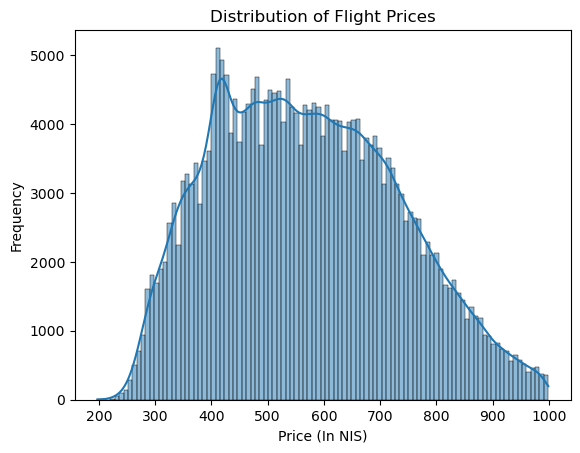

In [ ]:
#1 התפלגות מחירי הטיסות בכללי
sns.histplot(flight_data['Price'], kde=True)
plt.title('Distribution of Flight Prices')
plt.xlabel('Price (In NIS)')
plt.ylabel('Frequency')
plt.show()

Conclusions from the graph:

1. **Price distribution with a peak around 400 NIS**: Most prices are in the range of 300 to 500 NIS, with a peak around 400 NIS.
2. **Long tail distribution**: There is a decrease in the availability of prices above 600 NIS, with a less dense distribution.
3. **High variance**: The graph shows significant variability in prices, especially in the higher ranges.

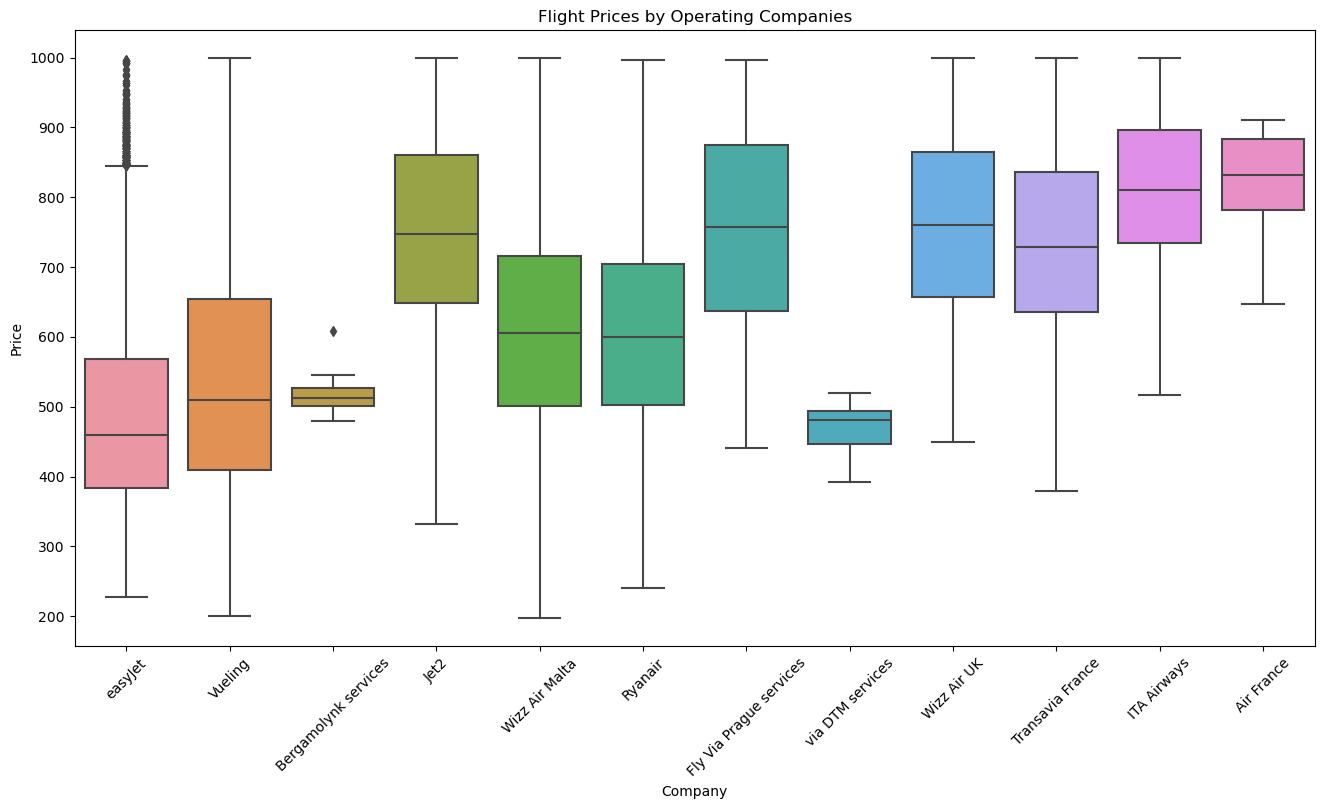

In [8]:
#2 מחירי הטיסות בהינתן חברות מפעילות
plt.figure(figsize=(16, 8))
sns.boxplot(x='Dep Company', y='Price', data=flight_data)
plt.xticks(rotation=45)
plt.title('Flight Prices by Operating Companies')
plt.xlabel('Company')
plt.ylabel('Price')
plt.show()

Conclusions from the graph:

1. **Low-cost airlines**: easyJet and Vueling show lower prices with a narrow range.
2. **Higher-priced airlines**: Air France and ITA Airways have higher prices with a wider range.
3. **Price distribution**: Most airlines show a similar price range, but there are outliers with exceptionally expensive flights.

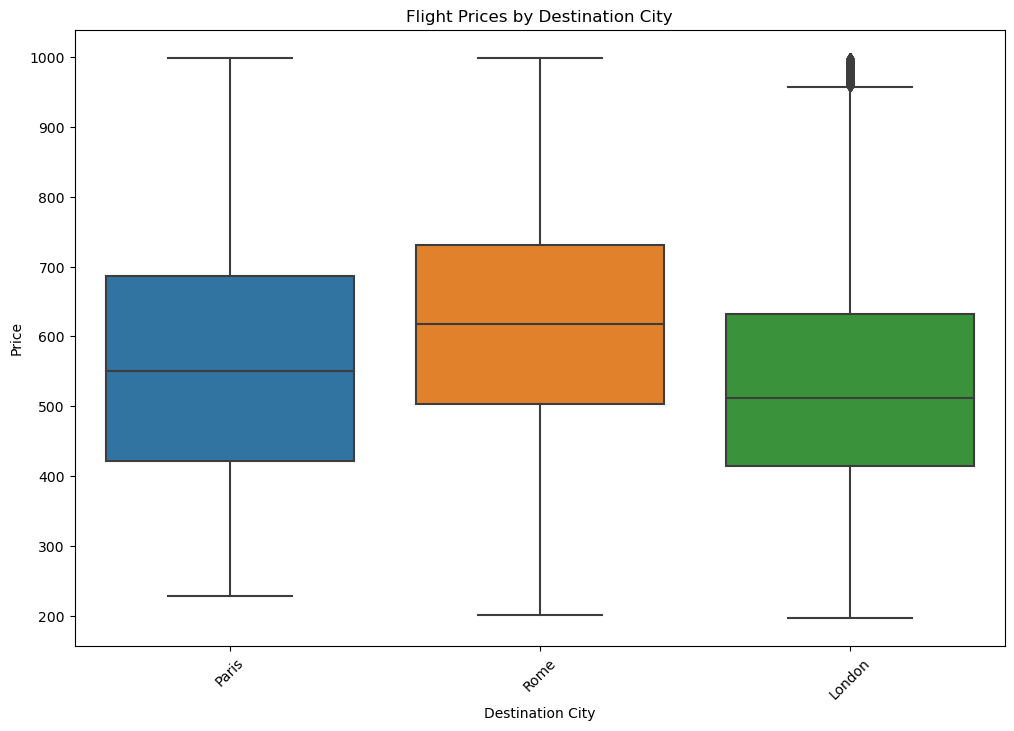

In [9]:
#3.1 *מחירי הטיסות על פי יעדים שונים, עשיתי בהמשך עוד אחד *לפי כל מקור
plt.figure(figsize=(12, 8))
sns.boxplot(x='Landing City', y='Price', data=flight_data)
plt.title('Flight Prices by Destination City')
plt.xlabel('Destination City')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

Conclusions from the graph:

1. **Similar prices**: Prices for Paris and Rome are similar, with a median around 500-600 NIS.
2. **London** shows higher prices, with a median around 700 NIS.
3. **Wider distribution in London**: London has a wider price range, including some very expensive flights.

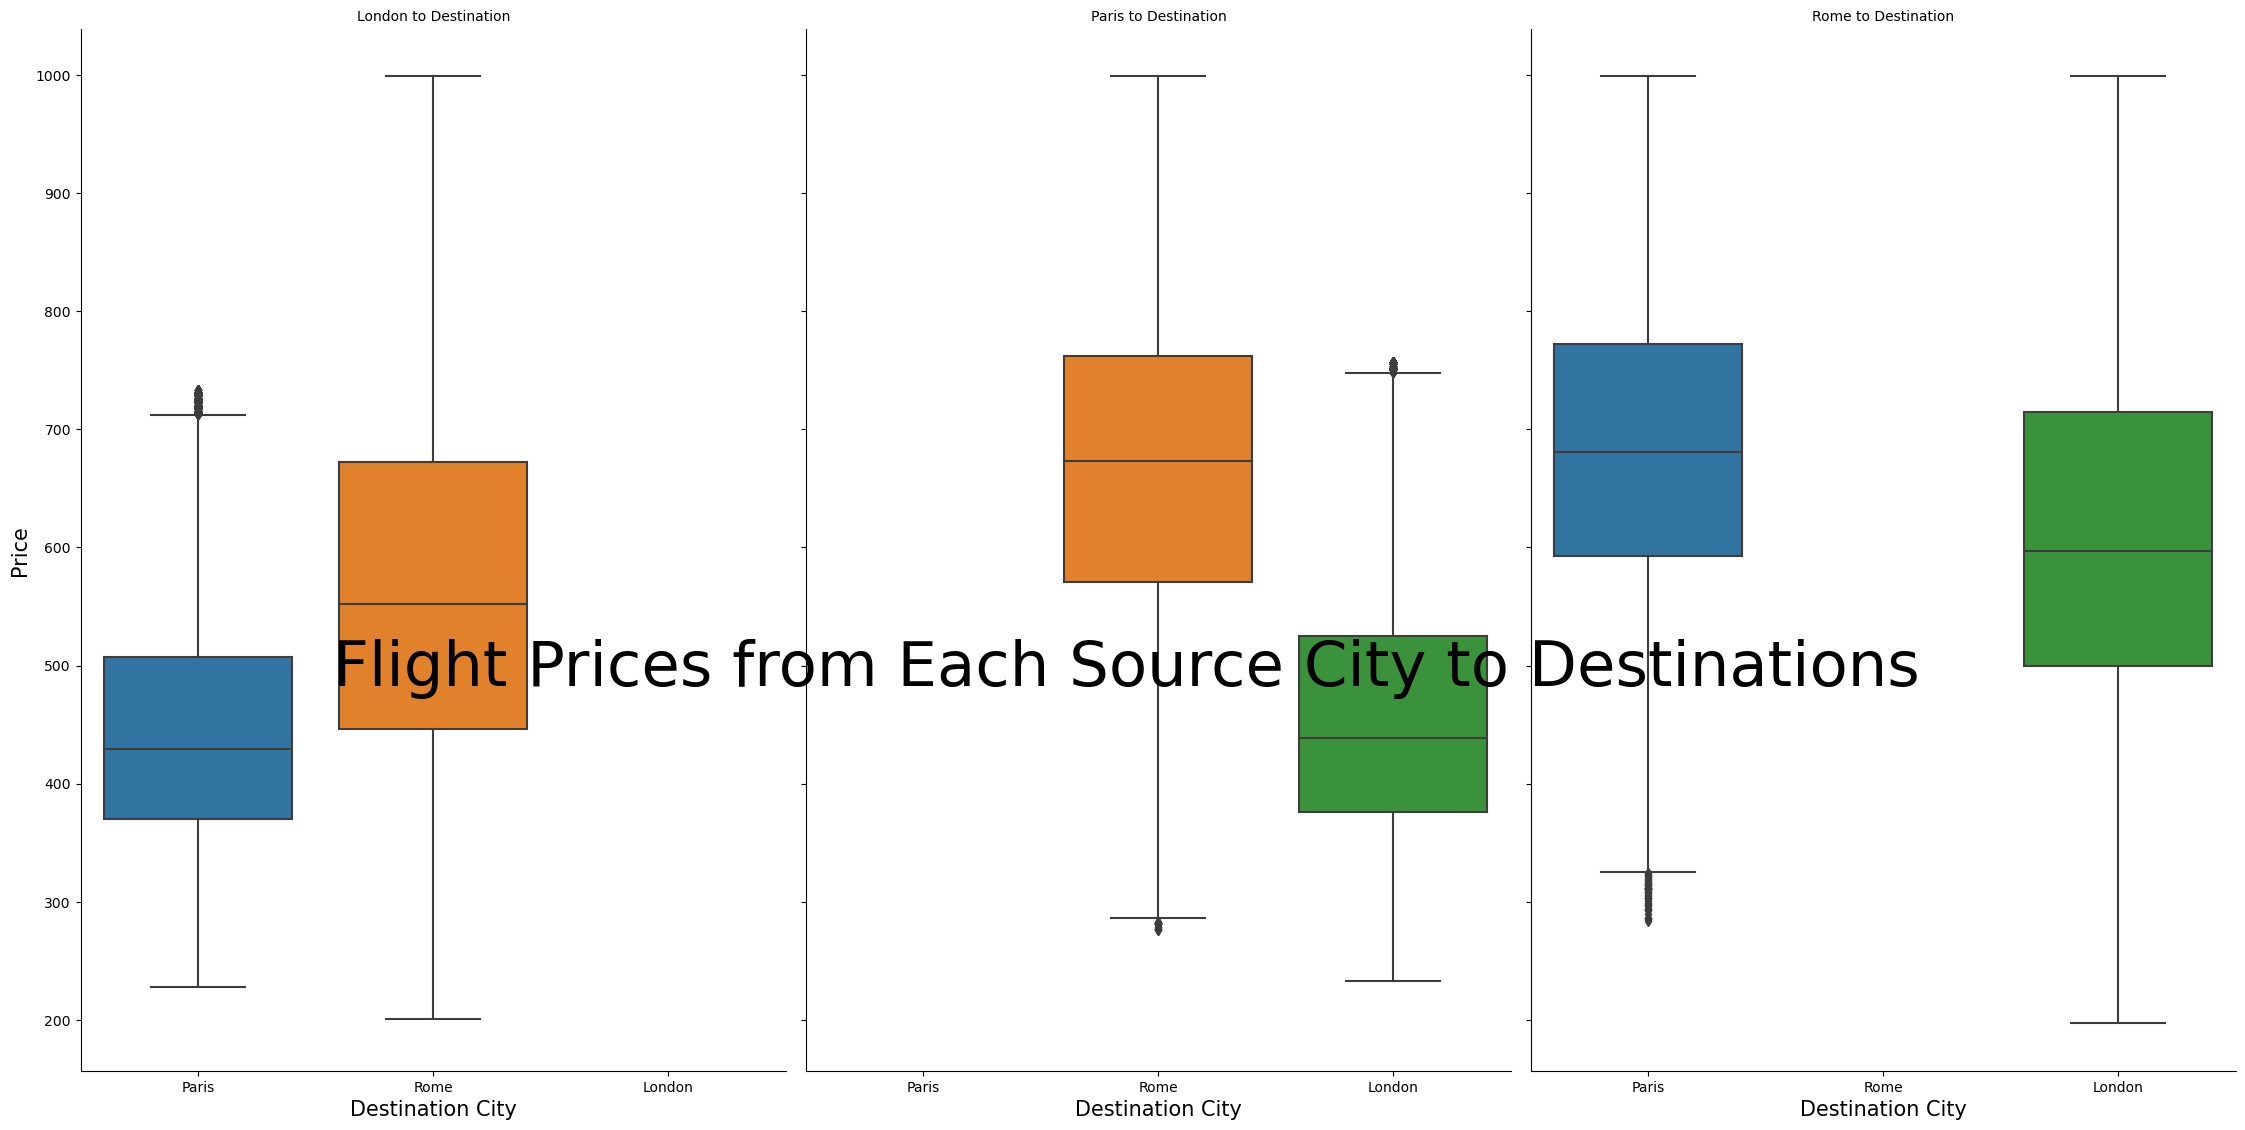

In [ ]:
#3.2 מחירי הטיסות על פי יעדים שונים לפי כל מקור!
relevant_data = flight_data[
    (flight_data['From City'].isin(['Paris', 'Rome', 'London'])) & 
    (flight_data['Landing City'].isin(['Paris', 'Rome', 'London']))
]
# Plotting the distribution of flight prices for each route from every source city
g = sns.catplot(
    x='Landing City', 
    y='Price', 
    col='From City', 
    data=relevant_data, 
    kind='box',
    height=5, 
    aspect=1.5,
    col_wrap=3 ,
)
g.set_titles("{col_name} to Destination")
g.set_axis_labels("Destination City", "Price",fontsize=15)
g.set_xticklabels()
plt.subplots_adjust(top=2.2)
g.fig.suptitle('Flight Prices from Each Source City to Destinations',fontsize=45)
plt.show()

Conclusions from the graph:

1. **Lower prices for flights from London**: Flights from London to different destinations show lower prices, especially to Paris.
2. **Higher prices for flights from Rome**: Flights from Rome show higher prices, especially to London.
3. **Similar distribution**: Prices for flights from Paris and London are similar in terms of price range and median.

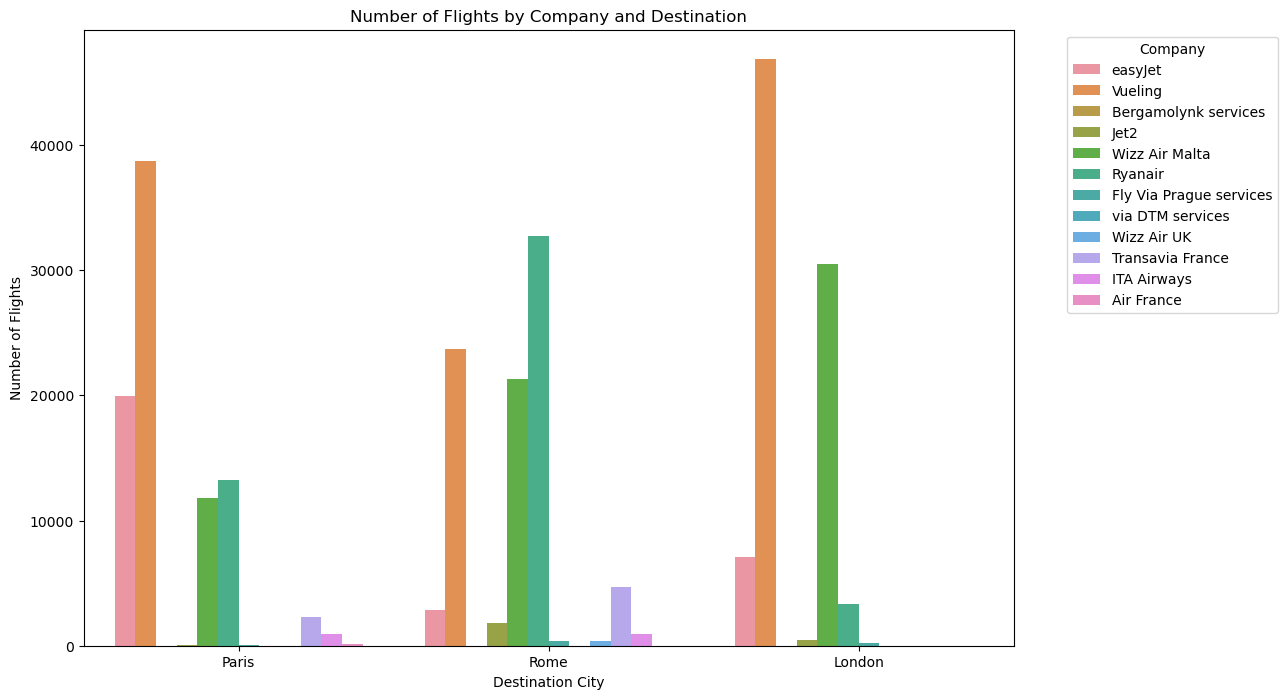

In [ ]:
#4 התפלגות הטיסות של חברות השונות על הטיסות פר יעד
plt.figure(figsize=(12, 8))
sns.countplot(x='Landing City', hue='Dep Company', data=flight_data)
plt.title('Number of Flights by Company and Destination')
plt.xlabel('Destination City')
plt.ylabel('Number of Flights')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks()
plt.show()

Conclusions from the graph:

1. **Paris** shows the highest number of flights, especially with **Vueling** and **easyJet**.
2. **Rome** has fewer flights, with **Wizz Air Malta** and **Jet2** leading.
3. **London** shows the second-highest number of flights, primarily with **Ryanair** and **Wizz Air Malta**.

In [12]:
# Clean and convert 'Stops' to numeric by using our function from earlier but this time on "flight_data".
flight_data['Stops'] = pd.to_numeric(flight_data['Stops'], errors='coerce')

# Filtering flights with 0,1 or 2 stops:
relevant_flights = flight_data[flight_data['Stops'].isin([0, 1, 2])]

# Applying the conversion function we used earlier to the 'Dep Duration' column of relevant_flights
relevant_flights['Dep Duration Minutes'] = relevant_flights['Dep Duration'].apply(lambda x: convert_duration_to_minutes(str(x)))

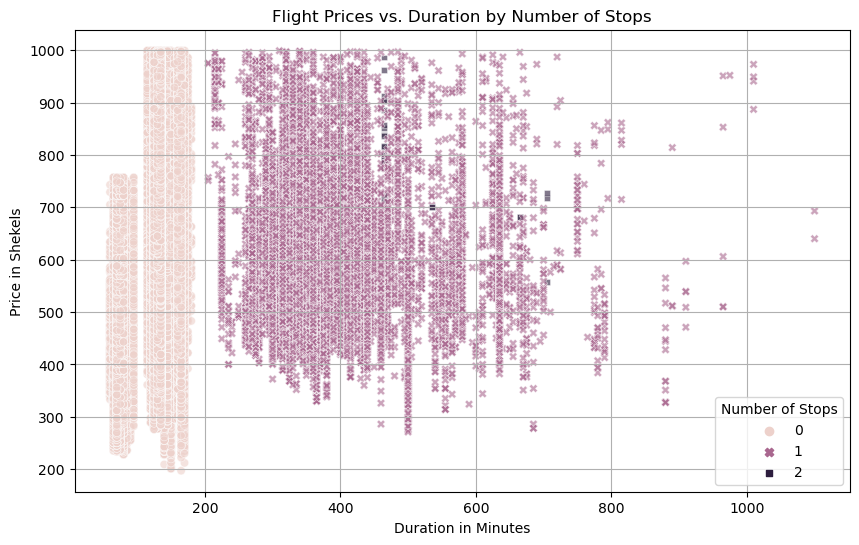

In [13]:
#5 התפלגות זמני קונקשן וזמני טיסות בין היעדים השונים
# 0,זמני קונקשן - 1,2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=relevant_flights, x='Dep Duration Minutes', y='Price', hue='Stops', style='Stops', alpha=0.6)
plt.title('Flight Prices vs. Duration by Number of Stops')
plt.xlabel('Duration in Minutes')
plt.ylabel('Price in Shekels')
plt.legend(title='Number of Stops')
plt.grid(True)
plt.show()

Conclusions from the graph:

1. **Lower prices with fewer stops**: Non-stop flights (0 Stops) show lower prices, especially for shorter durations.
2. **Wider distribution with 1 or 2 stops**: Flights with 1 or 2 stops show a wider price distribution, especially for longer flights.
3. **Longer flight duration with more stops**: Flights with 1 or 2 stops tend to be longer, but they are not necessarily more expensive.

c:\Users\liort\anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


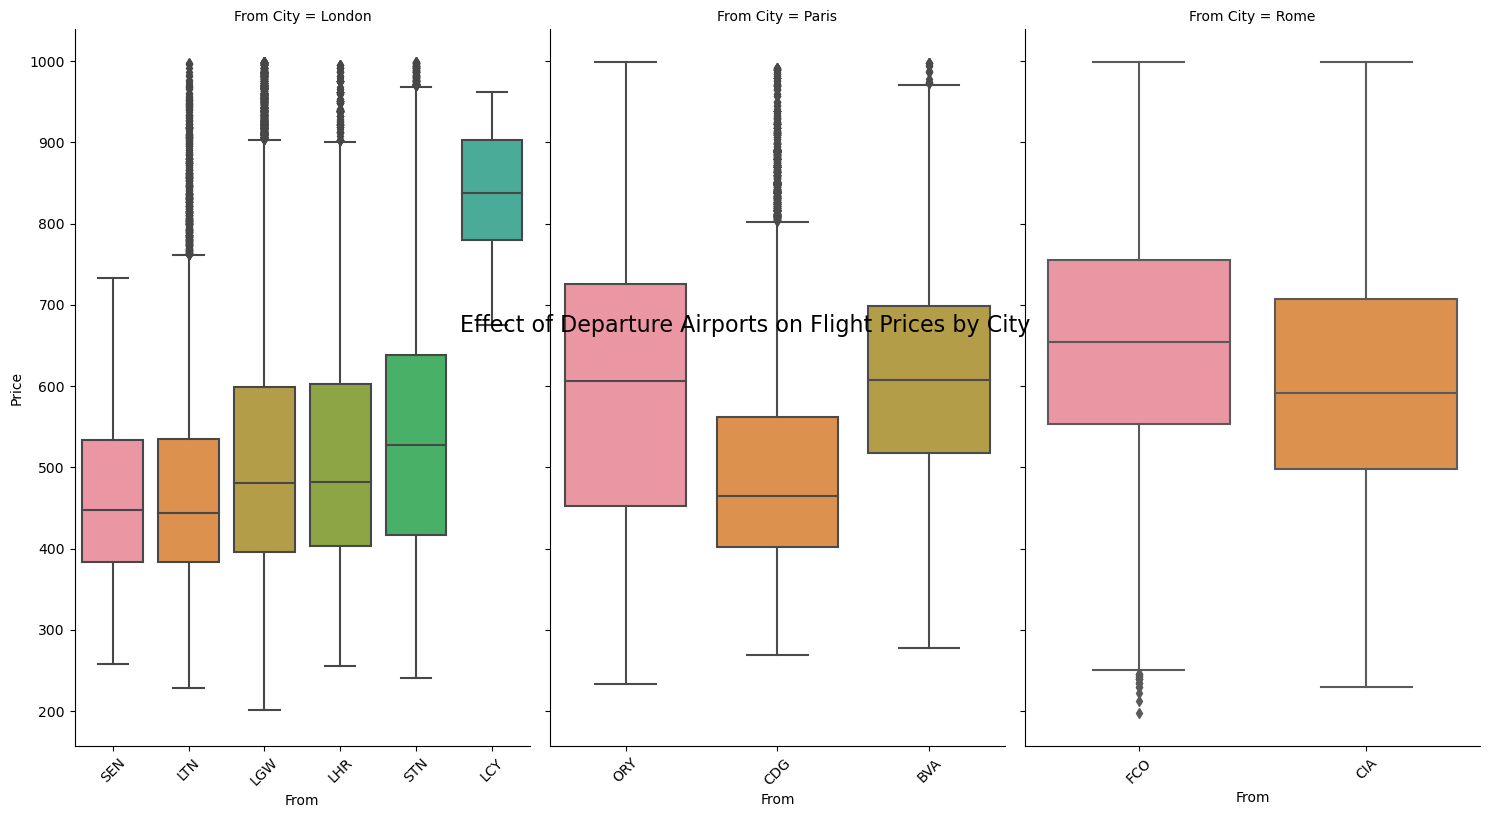

In [14]:
#6 השפעת שדות התעופה בכל עיר על המחירים של הטיסות בין היעדים
g = sns.catplot(
    x='From',
    y='Price',
    col='From City',
    data=flight_data,
    kind='box',
    col_wrap=3,
    height=5,
    aspect=1,
    sharex=False  # ככה שזה יבדיל ויצמיד לכל עיר את השדות תעופה הרלוונטים לו
)

# Rotate labels for readability
g.set_xticklabels(rotation=45)
g.fig.suptitle('Effect of Departure Airports on Flight Prices by City', fontsize=16)
plt.subplots_adjust(top=1.55)  # Move plots down to make space for the title
plt.show()

Conclusions from the graph:

1. **London**: There is significant price variation between airports. **LHR** shows particularly high prices, while **SEN** and **STN** show lower prices.
2. **Paris**: There is less price variation, with airports **CDG** and **ORY** showing similar prices, and **BVA** displaying lower prices.
3. **Rome**: Flights from **FCO** show higher prices, especially compared to **CIA**, where the prices are lower.

C:\Users\liort\AppData\Local\Temp\ipykernel_7888\4083589084.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(relevant_flights[cols_to_use].corr(), annot=True, cmap='coolwarm', fmt='.2f')


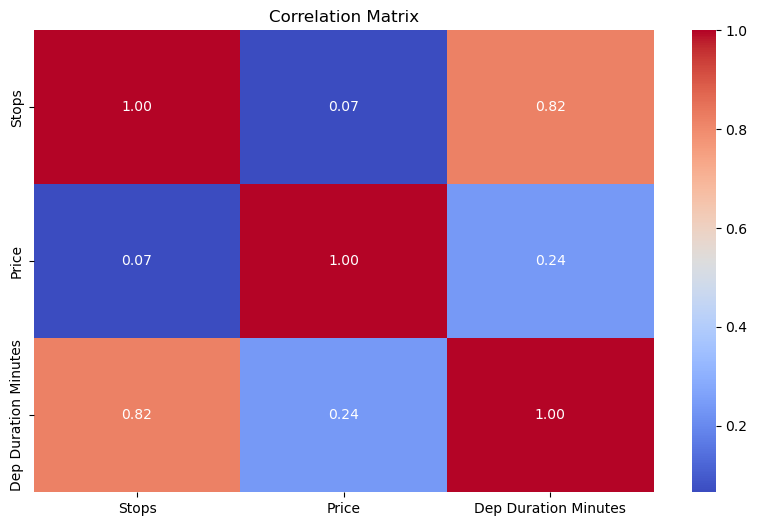

In [ ]:
# מטריצת מתאמים בין משתנים מספריים PairGrid
plt.figure(figsize=(10,6))
cols_to_use = [c for c in relevant_flights.columns if c != 'Stops.1']
sns.heatmap(relevant_flights[cols_to_use].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

<span style="color:green; font-weight:bold; font-size:1.6em">
    Conclusions from the PairGrid:
    </span>
    
<span style="color:red; font-weight:bold">  1. Stops and Departure Duration </span> 
have a **strong** positive correlation (~0.82).<br>
Intuitively, more stops often means a longer total travel time.
    
<span style="color:red; font-weight:bold">  2. Stops and Price </span> 
show only a **weak** positive correlation (~0.07).<br>
In other words, the number of stops doesn’t appear to drive the fare in our sample as strongly as the overall travel time does.

    
<span style="color:red; font-weight:bold">  3. Price and Departure Duration </span> 
have a **moderate** positive correlation (~0.24). <br>
Longer flights may cost a bit more on average, but the relationship is not as strong as the one between stops and travel duration.

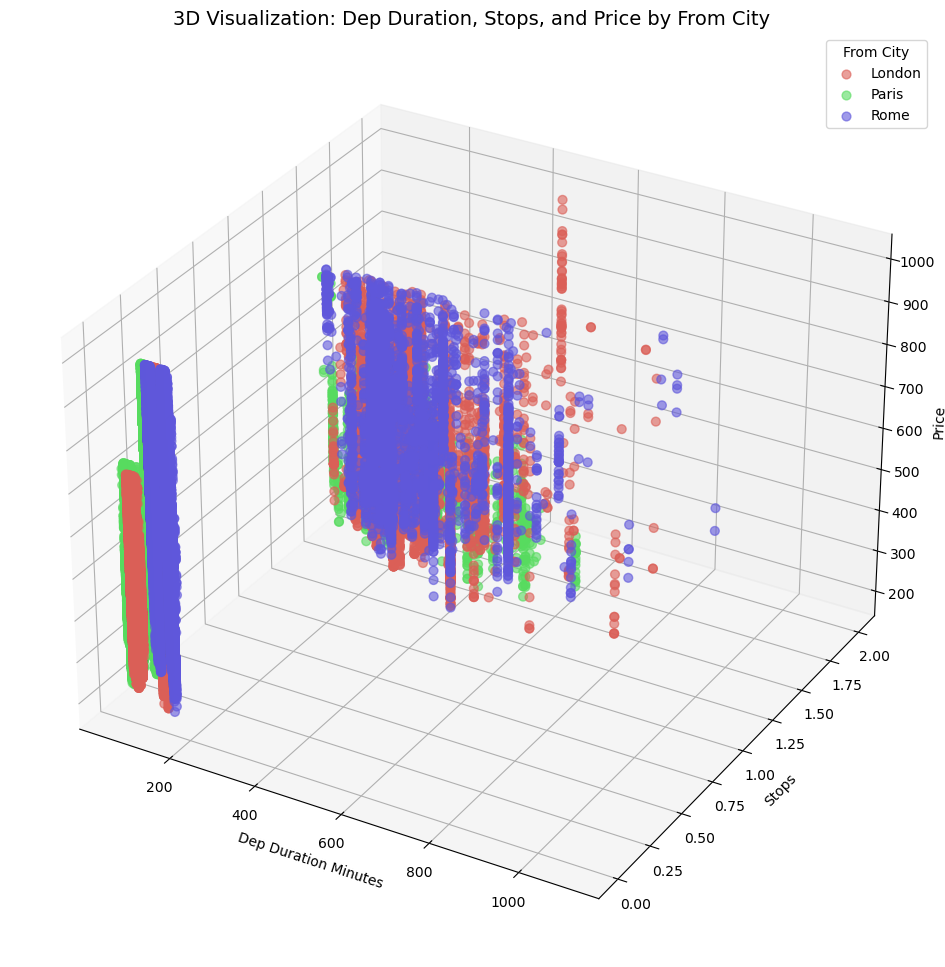

In [16]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# We'll color-code by the departure city
cities = relevant_flights['From City'].unique()
colors = sns.color_palette('hls', len(cities))

# Plot each city in a different color
for city, color in zip(cities, colors):
    subset = relevant_flights[relevant_flights['From City'] == city]
    ax.scatter(
        subset['Dep Duration Minutes'],
        subset['Stops'],
        subset['Price'],
        color=color,
        label=city,
        alpha=0.6,
        s=40
    )

# Set axis labels
ax.set_xlabel('Dep Duration Minutes')
ax.set_ylabel('Stops')
ax.set_zlabel('Price')

# Add a legend
ax.legend(title='From City')

# Set a title
plt.title('3D Visualization: Dep Duration, Stops, and Price by From City', fontsize=14)

plt.show()

Conclusions from the graph:

1. **London** (red) shows flights with shorter durations (under 300 minutes), especially with fewer stops.
2. **Rome** (blue) shows longer flights, particularly those with more stops.
3. **Paris** (green) has a distribution similar to London.
4. **Prices**: Prices are higher for longer flights or those with more stops, but not necessarily based on the departure city.

In [18]:
flight_data = pd.read_csv('flight_data_momondo_All_combined_Cloud.csv') #קריאת הנתונים

# Define airport to city mappings
airport_to_city = {
    'BVA': 'Paris', 'ORY': 'Paris', 'PAR': 'Paris', 'CDG': 'Paris',
    'CIA': 'Rome', 'FCO': 'Rome',
    'SEN': 'London', 'LCY': 'London', 'STN': 'London', 'LHR': 'London', 'LGW': 'London', 'LTN': 'London'
}

# Airports to cities
flight_data['From City'] = flight_data['From Airport'].map(airport_to_city)
flight_data['Landing City'] = flight_data['Landing Airport'].map(airport_to_city)

# Ensuring all data needed for mapping is properly addressed
print(flight_data[['From Airport', 'From City', 'Landing Airport', 'Landing City']].head())
allowed_airports = ['LGW', 'LHR', 'SEN', 'LTN', 'LON', 'STN', 'LCY', 'ORY', 'CDG', 'PAR', 'BVA', 'FCO', 'CIA']

# Filter the DataFrame to keep only rows with allowed airports in the 'From Airport' column
flight_data = flight_data[flight_data['From Airport'].isin(allowed_airports)]

  From Airport From City Landing Airport Landing City
0          LGW    London             ORY        Paris
1          LHR    London             ORY        Paris
2          LGW    London             ORY        Paris
3          LGW    London             ORY        Paris
4          LGW    London             ORY        Paris


C:\Users\liort\AppData\Local\Temp\ipykernel_7888\29360979.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_data = pd.read_csv('flight_data_momondo_All_combined_Cloud.csv') #קריאת הנתונים


In [ ]:
# Function to convert duration to minutes
def convert_duration_to_minutes(duration):
    hours, minutes = 0, 0
    # Extract hours and minutes using regex
    match = re.match(r'(\d+)h (\d+)m', duration)
    if match:
        hours, minutes = int(match.group(1)), int(match.group(2))
    else:
        match = re.match(r'(\d+)h', duration)
        if match:
            hours = int(match.group(1))
        match = re.match(r'(\d+)m', duration)
        if match:
            minutes = int(match.group(1))
    return hours * 60 + minutes

In [20]:
# Clean the 'Price' column: Remove any non-digit characters and convert to float
flight_data['Price'] = flight_data['Price'].str.extract('(\d+)', expand=False).astype(float)

# Check if there are any null values in the 'Price' column
print(flight_data['Price'].isnull().sum())

1171


In [ ]:
# Function to remove outliers for each combination of source and destination city
# Removing outliers using the Tukey (1.5IQR) method 
def remove_outliers(df):
    Q1 = df['Price'].quantile(0.25) #רצינו לשנות פה ולבדוק אם אפשר להוריד יותר אאוטליירס
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Appling the function for each city pair
cleaned_data = flight_data.groupby(['From City', 'Landing City']).apply(remove_outliers).reset_index(drop=True)

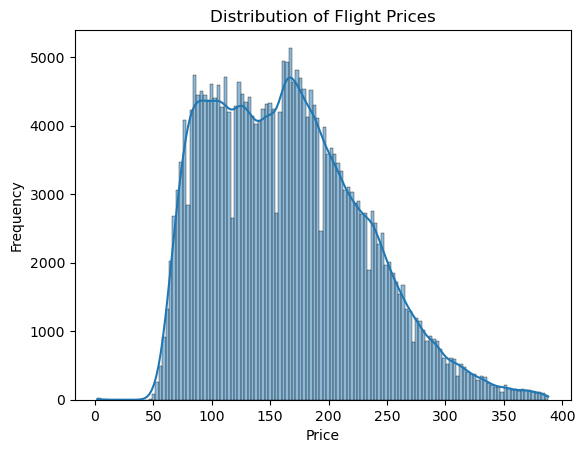

In [ ]:
#1 התפלגות מחירי הטיסות בכללי
sns.histplot(cleaned_data['Price'], kde=True)
plt.title('Distribution of Flight Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(76, 165, 224);
        margin-top: 20px;
    }
    .content {
        font-size: 16px;
        color:rgb(102, 158, 214);
        marginrgb(134, 182, 229)5px;
        line-height: 1.6;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
    .key-findings {
        font-weight: bold;
        color: #27ae60;
    }
</style>

<div class="subtitle">📊 Distribution of Flight Prices</div>

---

<div class="subtitle"> Key Observations</div>

<div class="content">
 The distribution of flight prices shows a **right-skewed shape**, meaning that <span class="highlight">most flights are relatively affordable</span>, while a smaller number of flights have significantly higher prices.<br>
 The **highest frequency of flights** falls within the **100 - 200 price range**, suggesting that the majority of flights are within this budget.<br>
 The **gradual decline in frequency** beyond 200 indicates that premium flights or last-minute bookings tend to be more expensive.<br>
 There are **multiple peaks in the distribution**, which may indicate pricing clusters based on airline type, booking class, or seasonality.<br>
 **Very few flights are priced below 50**, suggesting that extremely low-budget flights are rare.<br>
</div>

---

<div class="subtitle"> Conclusions</div>

<div class="content">
 **Most flights fall within a predictable price range** (100 - 200), making this a common pricing bracket for travelers.<br>
 **Luxury or last-minute flights** tend to be **less frequent but significantly more expensive**.<br>
 The **multi-modal nature of the distribution** suggests that pricing strategies vary based on multiple factors (e.g., demand, airline type, route distance).<br>
 **Budget-conscious travelers** should aim to book flights in the **most common price range** to avoid higher ticket costs.<br>
</div>


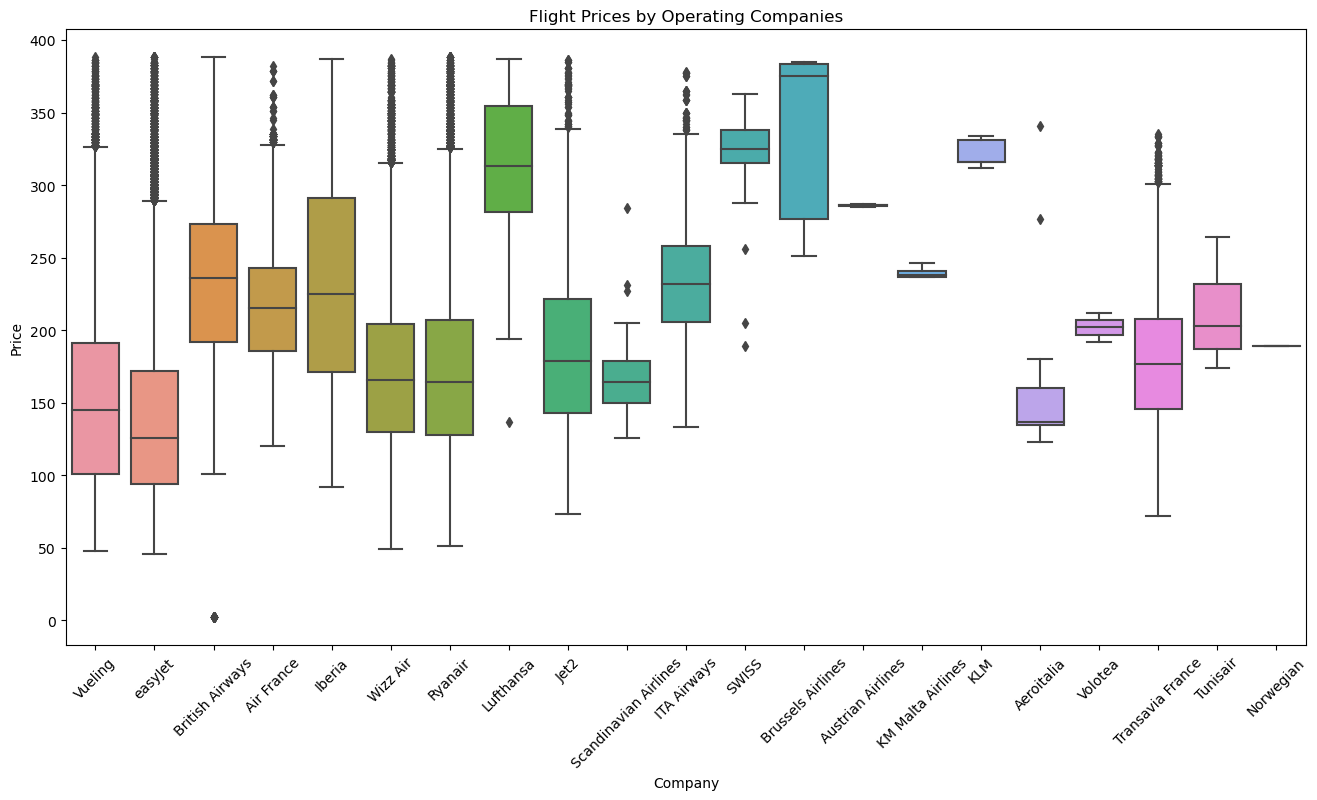

In [23]:
#2 מחירי הטיסות בהינתן חברות מפעילות
plt.figure(figsize=(16, 8))
sns.boxplot(x='Dep Company', y='Price', data=cleaned_data)
plt.xticks(rotation=45)
plt.title('Flight Prices by Operating Companies')
plt.xlabel('Company')
plt.ylabel('Price')
plt.show()

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(111, 177, 221);
        margin-top: 20px;
    }
    .content {
        font-size: 16px;
        color:rgb(196, 226, 255);
        margin-left: 15px;
        line-height: 1.6;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
    .key-findings {
        font-weight: bold;
        color: #27ae60;
    }
</style>

<div subclass="title">📊 Flight Prices by Operating Companies </div>

---

<div class="subtitle"> Key Observations</div>

<div class="content">
✅ Airlines exhibit <span class="key-findings">significant price variability</span>, with some offering more consistent pricing than others.<br>
✅ <span class="highlight">Budget airlines (e.g., Vueling, easyJet, Ryanair, Wizz Air)</span> generally have lower median prices but show a wide spread, indicating pricing fluctuations based on demand and booking time.<br>
✅ <span class="highlight">Premium carriers (e.g., Lufthansa, SWISS, British Airways)</span> tend to have higher median prices with a narrower interquartile range, suggesting more stable pricing.<br>
✅ Certain airlines (e.g., Scandinavian Airlines, ITA Airways) have a wider range of pricing, indicating high variability, potentially due to multiple fare classes.<br>
✅ <span class="key-findings">Some outliers</span> exist in all airlines, with extreme high prices possibly linked to last-minute bookings, premium services, or specific routes.<br>
</div>


<div class="subtitle"> Conclusions</div>

<div class="content">
 **Low-cost carriers** tend to have a **wide price range** but lower medians, making them suitable for budget-conscious travelers.<br>
️ **Full-service airlines** offer **more stable pricing** but at a **higher cost**.<br>
️ **Airlines with high price dispersion** may cater to **both budget and premium passengers**, leading to broad price variations.<br>
 **Understanding airline pricing strategies** can help in choosing the right carrier based on travel budget and flexibility.<br>
</div>


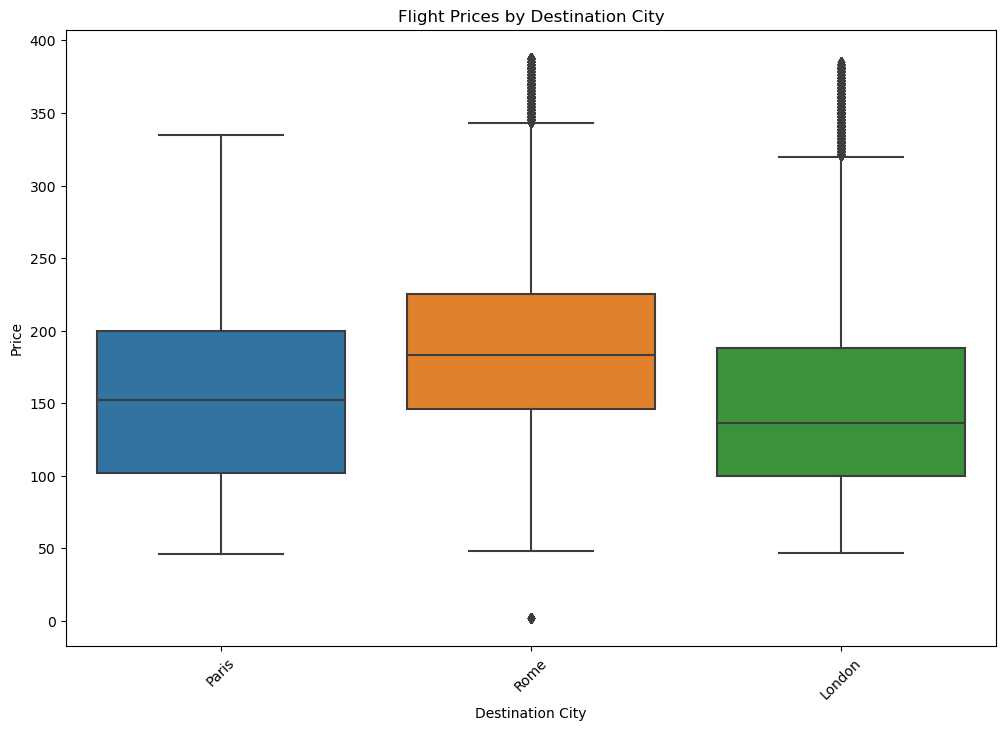

In [24]:
#3.1 מחירי הטיסות על פי יעדים שונים
plt.figure(figsize=(12, 8))
sns.boxplot(x='Landing City', y='Price', data=cleaned_data)
plt.title('Flight Prices by Destination City')
plt.xlabel('Destination City')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

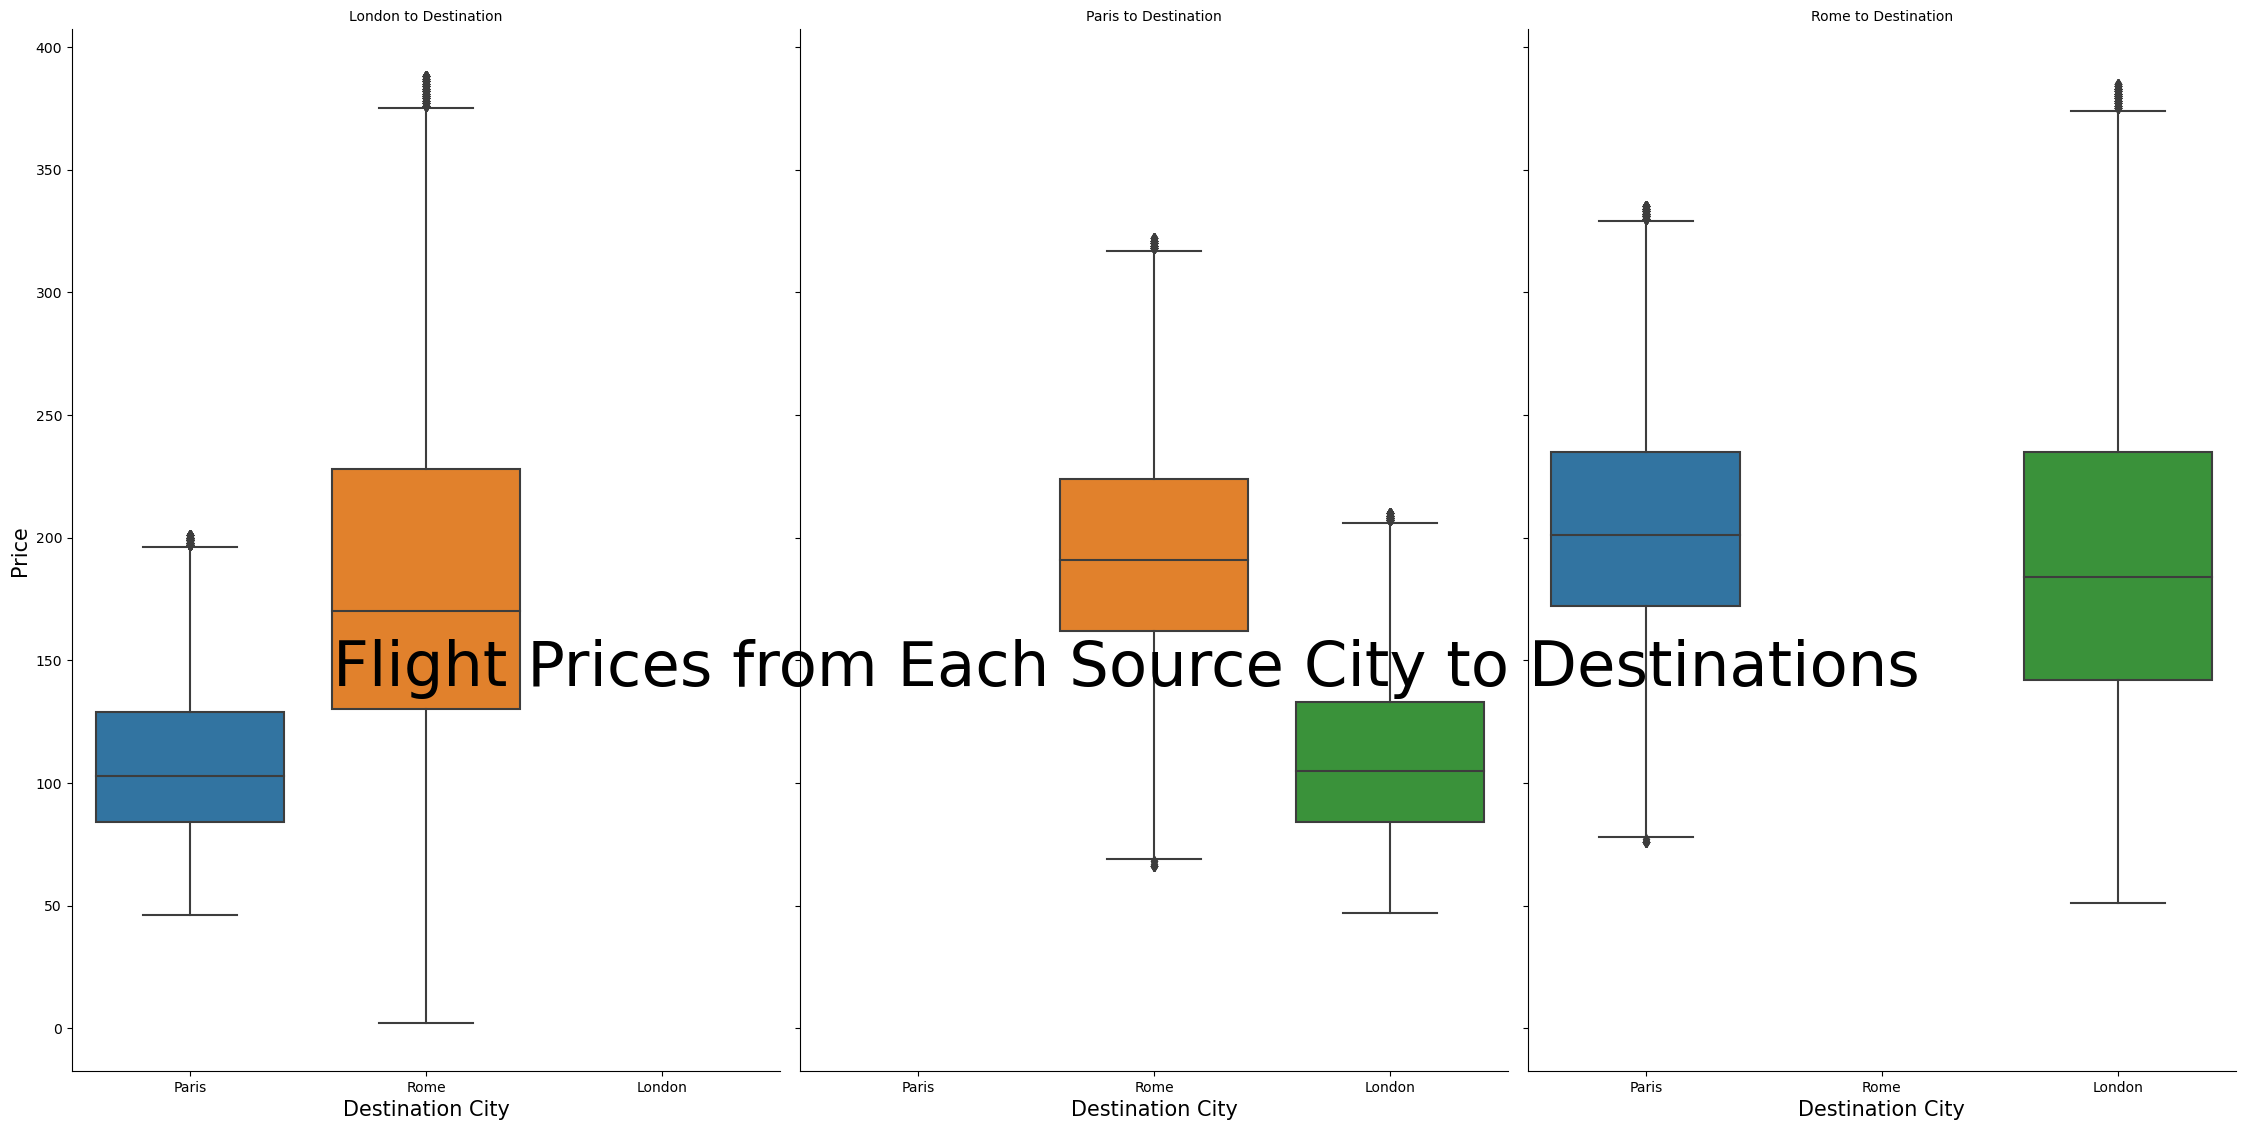

In [ ]:
#3.2 מחירי הטיסות על פי יעדים שונים לפי כל מקור!
relevant_data = cleaned_data[
    (cleaned_data['From City'].isin(['Paris', 'Rome', 'London'])) & 
    (cleaned_data['Landing City'].isin(['Paris', 'Rome', 'London']))
]
# Plotting the distribution of flight prices for each route from every source city
g = sns.catplot(
    x='Landing City', 
    y='Price', 
    col='From City', 
    data=relevant_data, 
    kind='box',
    height=5, 
    aspect=1.5,
    col_wrap=3 ,
)
g.set_titles("{col_name} to Destination")
g.set_axis_labels("Destination City", "Price",fontsize=15)
g.set_xticklabels()
plt.subplots_adjust(top=2.2)
g.fig.suptitle('Flight Prices from Each Source City to Destinations',fontsize=45)
plt.show()

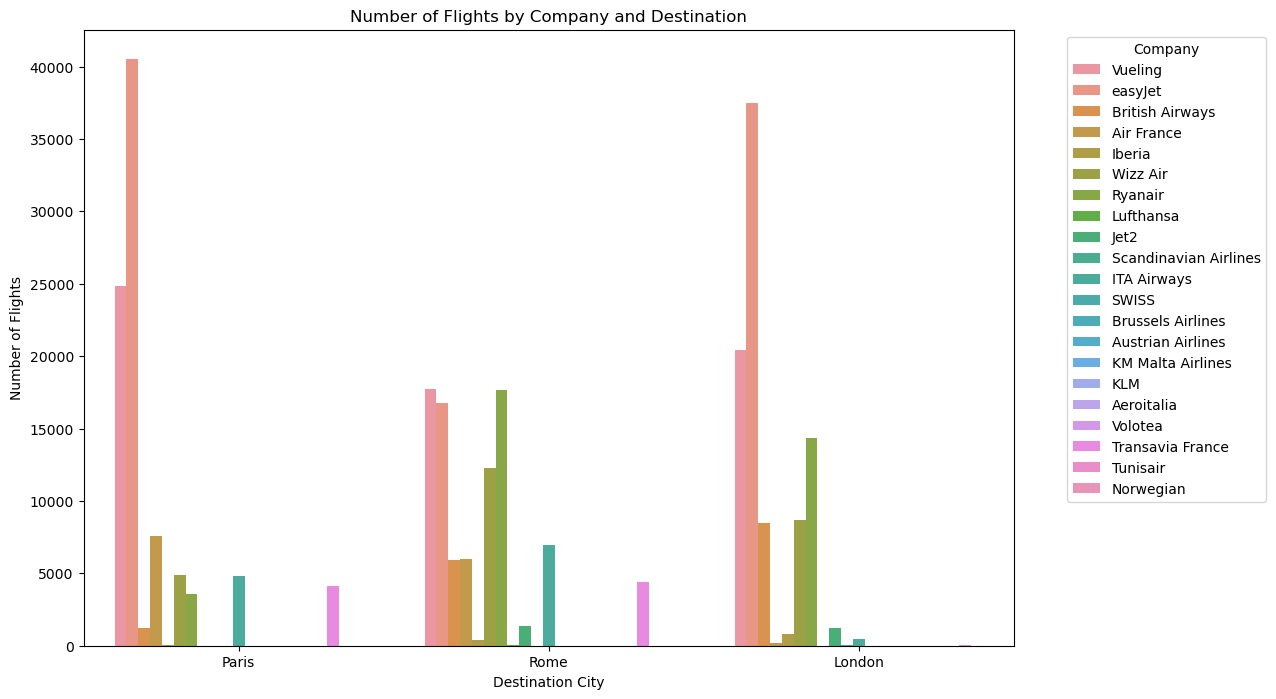

In [ ]:
#4 התפלגות הטיסות של חברות השונות על הטיסות פר יעד
plt.figure(figsize=(12, 8))
sns.countplot(x='Landing City', hue='Dep Company', data=cleaned_data)
plt.title('Number of Flights by Company and Destination')
plt.xlabel('Destination City')
plt.ylabel('Number of Flights')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks()
plt.show()

In [27]:
# Clean and convert 'Stops' to numeric by using our function from earlier but this time on "flight_data".
flight_data['Stops'] = pd.to_numeric(flight_data['Stops'], errors='coerce')

# Filtering flights with 0,1 or 2 stops:
relevant_flights = flight_data[flight_data['Stops'].isin([0, 1, 2])]

# Applying the conversion function we used earlier to the 'Dep Duration' column of relevant_flights
relevant_flights['Dep Duration Minutes'] = relevant_flights['Dep Duration'].apply(lambda x: convert_duration_to_minutes(str(x)))

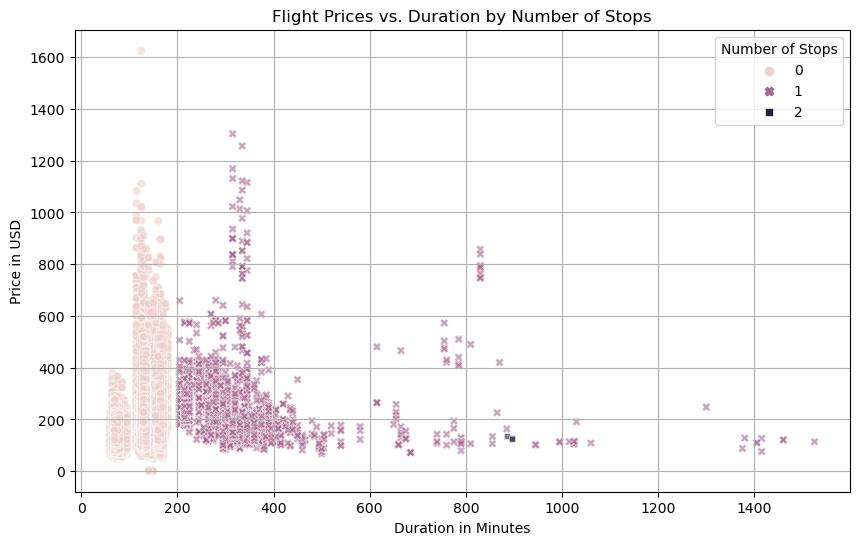

In [28]:
#5 התפלגות זמני קונקשן וזמני טיסות בין היעדים השונים
# 0,זמני קונקשן - 1,2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=relevant_flights, x='Dep Duration Minutes', y='Price', hue='Stops', style='Stops', alpha=0.6)
plt.title('Flight Prices vs. Duration by Number of Stops')
plt.xlabel('Duration in Minutes')
plt.ylabel('Price in USD')
plt.legend(title='Number of Stops')
plt.grid(True)
plt.show()

                                                                                               :מסקנות

                        נראה שיש קשר בן זמני טיסה ארוכים מהרגיל למחירם המוזל יותר (שכנראה עקב כך)

                                           -נראה כי עד ה300 דקות יש התפלגות נורמאלית המזכירה פעמון
     ..כי לפי הנראה- בטווח של עד 5 שעות ב*טיסות ישירות*- ככל שהטיסה לוקחת יותר זמן היא יותר יקרה
              .כנראה שבגלל שהיעד יותר רחוק ולכן המחיר עולה לפי עלויות טכניות כמו דלק ומשאבי אנוש
    
      כלומר זה לא באמת התפלגות פעמון אם מתייחסים לטיסות ישירות ולטיסות קונקשן בנפרד- אלא עליה לינארית


In [29]:
#ניקוי והכנת הדאטה עבור דרישה 6 - השפעת שדות התעופה בכל עיר על המחירים של הטיסות בין היעדים
flight_data['Dep City'] = flight_data['From Airport'].map(airport_to_city)
flight_data['Landing City'] = flight_data['Landing Airport'].map(airport_to_city)
airport_by_city = {
    'Paris': ['BVA', 'ORY', 'PAR', 'CDG'],
    'Rome':  ['CIA', 'FCO'],
    'London': ['SEN', 'LCR', 'STN', 'LGW', 'LTN', 'LHR']
}

#  Filter rows so that each row’s 'From Airport' is valid for the 'Dep City'
def is_valid_airport(row):
    city = row['Dep City']
    from_airport = row['From Airport']
    # Only keep the row if the from_airport is in the list of valid airports for that city
    if city in airport_by_city:
        return from_airport in airport_by_city[city]
    return False

flight_data['Is Relevant Airport'] = flight_data.apply(is_valid_airport, axis=1)
filtered_data = flight_data[flight_data['Is Relevant Airport']]

c:\Users\liort\anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


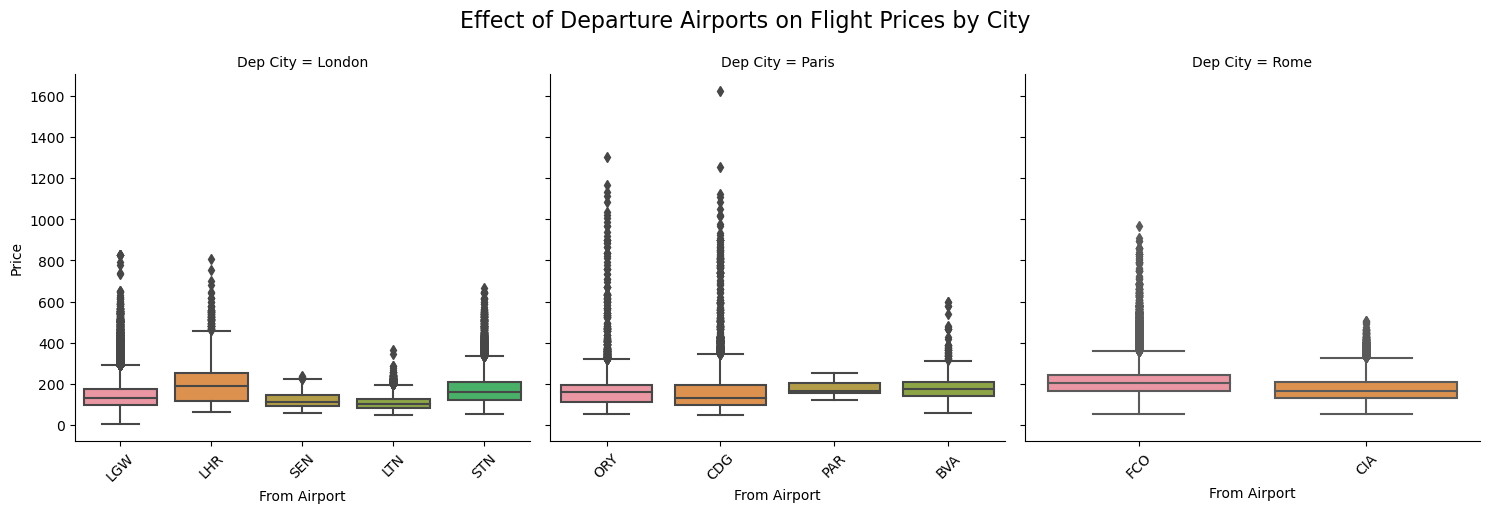

In [30]:
#6 השפעת שדות התעופה בכל עיר על המחירים של הטיסות בין היעדים
g = sns.catplot(
    x='From Airport',
    y='Price',
    col='Dep City',
    data=filtered_data,
    kind='box',
    col_wrap=3,
    height=5,
    aspect=1,
    sharex=False  # ככה שזה יבדיל ויצמיד לכל עיר את השדות תעופה הרלוונטים לו
)

# Rotate labels for readability
g.set_xticklabels(rotation=45)
g.fig.suptitle('Effect of Departure Airports on Flight Prices by City', fontsize=16)
plt.subplots_adjust(top=0.85)  # Move plots down to make space for the title
plt.show()

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(129, 196, 241);
        margin-top: 20px;
    }
    .content {
        font-size: 16px;
        color:rgb(169, 210, 252);
        margin-left: 15px;
        line-height: 1.6;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
    .key-findings {
        font-weight: bold;
        color: #27ae60;
    }
</style>

<div class="subtitle">✈️ Effect of Departure Airports on Flight Prices by City</div>

---

<div class="subtitle"> Key Observations</div>

<div class="content">
 Flight prices vary significantly depending on the **departure airport within each city**.<br>
 **London:** Heathrow (LHR) tends to have **higher median prices** compared to other London airports (e.g., Luton - LTN, Southend - SEN). Gatwick (LGW) and Stansted (STN) show more moderate pricing with **wider variability**.<br>
 **Paris:** Charles de Gaulle (CDG) exhibits **the highest price spread**, suggesting it serves both premium and budget flights. Orly (ORY) and Beauvais (BVA) show **lower median prices** with some extreme outliers.<br>
 **Rome:** The price distribution between **Fiumicino (FCO) and Ciampino (CIA) is more balanced**, with FCO showing **slightly higher price dispersion**.<br>
 All cities exhibit **price outliers**, likely representing **business-class, last-minute, or peak season flights**.<br>
</div>

---

<div class="subtitle"> Conclusions</div>

<div class="content">
✔️ **Major international airports (e.g., LHR, CDG, FCO) tend to have higher prices**, reflecting premium services, higher demand, and long-haul flights.<br>
✔️ **Budget-friendly airports (e.g., STN, BVA, CIA) offer lower median prices** but may have additional costs (e.g., transportation to the city center, baggage fees).<br>
✔️ Passengers looking for **cheaper flights** should consider **alternative airports** rather than major hubs.<br>
✔️ **Paris has the widest range of flight prices**, indicating **diverse flight offerings** from ultra-low-cost to premium travel.<br>
</div>


C:\Users\liort\AppData\Local\Temp\ipykernel_7888\1629745529.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(relevant_flights.corr(), annot=True, cmap='coolwarm', fmt='.2f')


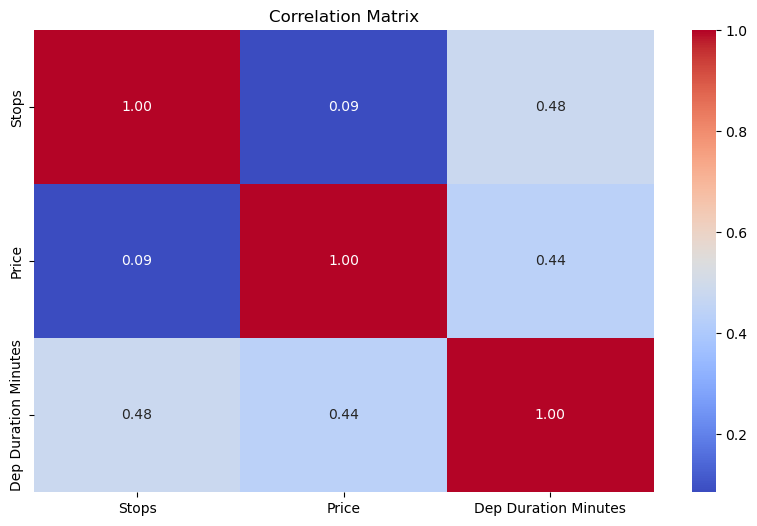

In [31]:
# מטריצת מתאמים בין משתנים מספריים
plt.figure(figsize=(10,6))
sns.heatmap(relevant_flights.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

<span style="color:green; font-weight:bold; font-size:1.6em">
    Conclusions from the PairGrid:
    </span>
    
<span style="color:red; font-weight:bold">  1. Stops and Departure Duration </span> 
They show a moderate positive correlation (~0.48).<br>
In plain language, flights with more stops tend to have a longer total duration, which makes intuitive sense.
    
<span style="color:red; font-weight:bold">  2. Stops and Price </span> 
They also exhibit a moderate positive correlation (~0.44).<br>
This suggests that flights with longer durations are somewhat more expensive, but not extremely so.

    
<span style="color:red; font-weight:bold">  3. Price and Departure Duration </span> 
This relationship is quite weak (~0.09). <br>
In other words, simply having more stops does not strongly affect the fare, at least not directly in this dataset (Momondo).

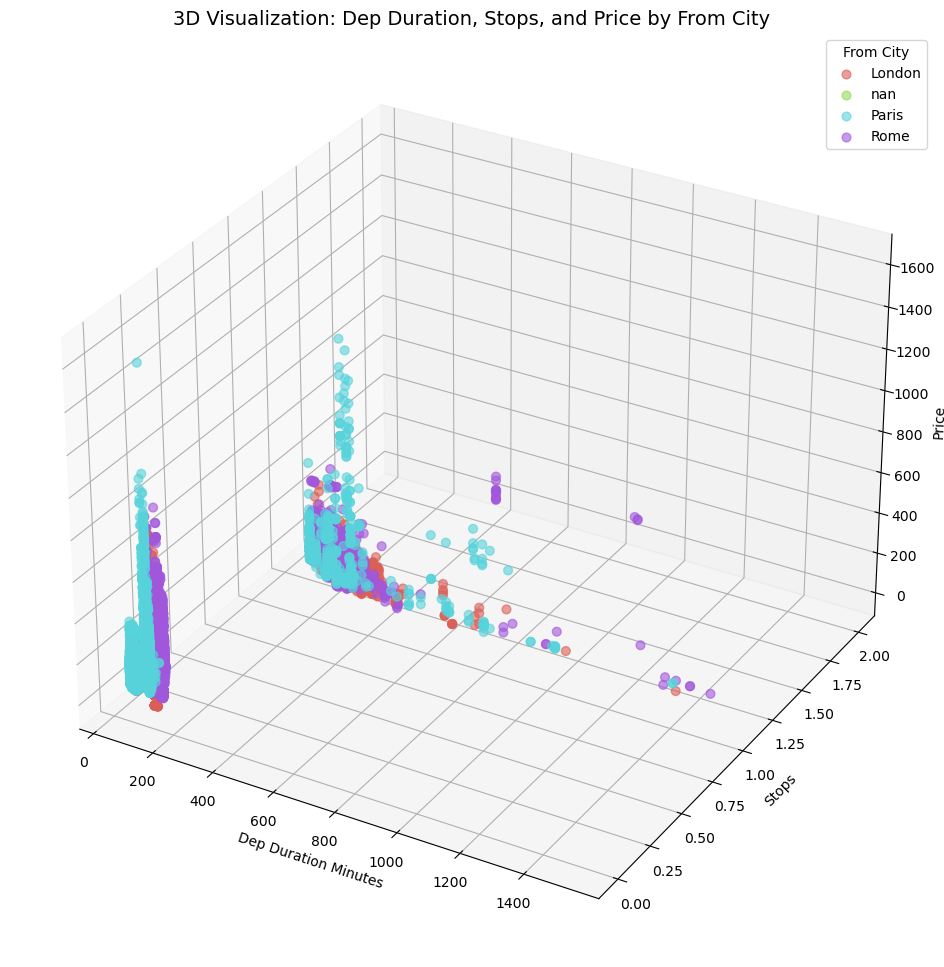

In [32]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# We'll color-code by the departure city
cities = relevant_flights['From City'].unique()
colors = sns.color_palette('hls', len(cities))

# Plot each city in a different color
for city, color in zip(cities, colors):
    subset = relevant_flights[relevant_flights['From City'] == city]
    ax.scatter(
        subset['Dep Duration Minutes'],
        subset['Stops'],
        subset['Price'],
        color=color,
        label=city,
        alpha=0.6,
        s=40
    )

# Set axis labels
ax.set_xlabel('Dep Duration Minutes')
ax.set_ylabel('Stops')
ax.set_zlabel('Price')

# Add a legend
ax.legend(title='From City')

# Set a title
plt.title('3D Visualization: Dep Duration, Stops, and Price by From City', fontsize=14)

plt.show()

**Conclusions from the graph:**

<span style="color:red; font-weight:bold">1. **London** (red)</span>  shows flights with shorter durations (under 300 minutes), especially with fewer stops. <br>
<span style="color:blue; font-weight:bold">2. **Rome** (blue)</span> shows longer flights, particularly those with more stops.<br>
<span style="color:green; font-weight:bold">3. **Paris** (green)</span> has a distribution similar to Rome.<br>
4. **Prices**: Prices are lower for longer flights or those with more stops, but not necessarily based on the departure city.